In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn-muted')
plt.style.use('ggplot')
import scipy.optimize as opt

## Funciones

In [2]:
def display_data(X, l=5, h=5):
    """
    Transforms each input row into a rectangular image part and plots
    the resulting image.
    """
    m, n = X.shape 
    
    example_width = int(np.around(np.sqrt(n))) # anchura de pixels
    example_height = int(n / example_width) # altura pixels
       
    # calcular filas y columnas de la matriz a mostrar
    display_rows = int(np.sqrt(m))
    display_cols = int(m / display_rows)   
    
    # padding entre las imagenes
    pad = 1
    
    display_array = -np.ones((pad + display_rows * (example_height + pad),  
                              pad + display_cols * (example_width + pad)))
    
   # Copy example into a patch on the display array
    curr_ex = 0
    
    for i in range(display_rows):
        for j in range(display_cols):
            
            if curr_ex < m:                
                
                # obtener maximo valor para normalizar ejemplos
                max_val = max(abs(X[curr_ex, :]))
            
                rows = pad + (i) * (example_height + pad) + np.array(range(example_height))
                cols = pad + (j) * (example_width + pad) + np.array(range(example_width ))
            
                img = np.reshape(X[curr_ex, :], (example_height, example_width))
                
                display_array[ rows[0]: rows[-1] + 1 , cols[0]: cols[-1] + 1 ] = img / max_val
                
                curr_ex += 1
           
            else:
                break          
             
    plt.figure(figsize=(l, h))
    plt.imshow(display_array.T, plt.cm.gray)
    plt.axis("off")
   
    plt.show()
# =========================================================================
def sigmoid(z):
    """
    SIGMOID Compute sigmoid function
    g = SIGMOID(z) computes the sigmoid of z.    
    """
    #inicializar variables
    g = np.zeros(z.shape)    
    g = 1. / (1 + np.exp(-z))
    
    return g
# =========================================================================
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, 
                   num_labels, X, y, lamda):
    """
    neural network which performs classification
    [J grad] = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, ...
    X, y, lambda) computes the cost and gradient of the neural network. The
    parameters for the neural network are "unrolled" into the vector
    nn_params and need to be converted back into the weight matrices. 

    The returned parameter grad should be a "unrolled" vector of the
    partial derivatives of the neural network.
    """
    
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network   
    
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], 
                        (hidden_layer_size, input_layer_size + 1), order='F')
    
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                        (num_labels, hidden_layer_size + 1), order='F') 
    
    # Setup some useful variables
    m = X.shape[0]
    
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape);
    Theta2_grad = np.zeros(Theta2.shape);
    p = np.zeros((m, ));
    
    # part 1
    # Add ones to the X data matrix
    a1 = np.hstack( (np.ones((m, 1)), X) )    
    a2 = sigmoid(a1@Theta1.T)
    a2 = np.hstack( (np.ones((m, 1)), a2) )  
    a3 = sigmoid(a2@Theta2.T);   
    # Probabilidades de predicciones
    h = a3 #np.argmax( a3, axis = 0 ) + 1
       
    # transformar y en una matriz
    y_matrix = np.zeros((m, num_labels))
    
    for i in range(m):
        y_matrix[i, y[i]-1] = 1    
    
    cost = 0    
    
    #error
    k_err = 1.0/m    
    err_1 = -y_matrix * np.log(h)    
    err_2 = (1-y_matrix) * np.log(1-h)    
    err = k_err * np.sum( np.sum((err_1 - err_2), axis=1) )
    
    #regularización
    k_lamda = (lamda*0.5)/m
    err_lamda_1 = np.sum( np.sum(np.power(Theta1[:,2:],2), axis=1) )
    err_lamda_2 = np.sum( np.sum(np.power(Theta2[:,2:],2), axis=1) )
    reg = k_lamda * (err_lamda_1 + err_lamda_2)
    
    J = err + reg
    
    return J
# ========================================================================= 

def sigmoidGradient(z):
    """
    SIGMOIDGRADIENT returns the gradient of the sigmoid function
    evaluated at z
    g = SIGMOIDGRADIENT(z) computes the gradient of the sigmoid function
    evaluated at z. This should work regardless if z is a matrix or a
    vector. In particular, if z is a vector or matrix, you should return
    the gradient for each element.
    """
    g = np.zeros(len(z))
    g = sigmoid(z)*(1.0-sigmoid(z))
    
    return g
# ========================================================================= 

def randInitializeWeights(L_in, L_out, epsilon_init = 0.12):
    """
    RANDINITIALIZEWEIGHTS Randomly initialize the weights of a layer with L_in
    incoming connections and L_out outgoing connections
    W = RANDINITIALIZEWEIGHTS(L_in, L_out) randomly initializes the weights 
    of a layer with L_in incoming connections and L_out outgoing 
    connections. 

    Note that W should be set to a matrix of size(L_out, 1 + L_in) as
    the first column of W handles the "bias" terms
    """    
    W = np.zeros((L_out, 1 + L_in))    
    
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    
    return W

## Inicialización

In [3]:
# configurar paramatros a utilizar
input_layer_size = 400 # imagenes de 20 x 20 pixels
hidden_layer_size = 25 # 25 unidades ocultas
num_labels = 10 # 10 labels de 1 a 10

## Parte 1: Cargando y Visualizando Datos

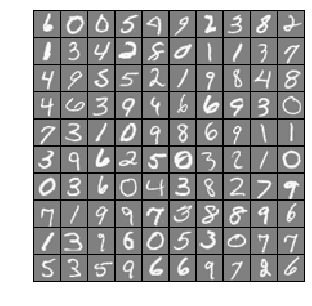

In [4]:
# cargar datos
data = io.loadmat('ex4data1.mat') #lectura de file .mat, cargados en un diccionario con X, y como llaves

X = data["X"]
y = data["y"]
y = y.reshape((len(y),))
m = X.shape[0]

# seleccionar aleatoriamente 100 data point para mostrar
rand_indices = np.random.permutation(m)
sel = X[rand_indices[0:100],:]

display_data(sel)


## Parte 2: Cargando Parametros

In [5]:
# cargar datos
parameter = io.loadmat('ex4weights.mat') #lectura de file .mat, cargados en un diccionario con X, y como llaves
Theta1 = parameter["Theta1"]
Theta2 = parameter["Theta2"]
#print(f"shape Theta1 = {Theta1.shape}, \nshape Theta2 = {Theta2.shape}")
#print(f"len :{len(X)}, shape:{X.shape}")
# unrroll Theta1 y Theta2
UTheta1 = np.reshape(Theta1, Theta1.size, order ="F")
UTheta2 = np.reshape(Theta2, Theta2.size, order ="F")

nn_params = np.concatenate((UTheta1, UTheta2))

## Parte 3: Calcular el costo (Feedforward)

In [6]:
print("Feedforward usando la Red Neuronal ...\n")

# Weight regularization parameter (we set this to 0 here).
lamda = 0
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamda)

print(f"parametros de costo (cargados de ex4weights):{J:5.8f}") 
print("(Este valor debe estar cerca de 0.287629)")

Feedforward usando la Red Neuronal ...

parametros de costo (cargados de ex4weights):0.28762917
(Este valor debe estar cerca de 0.287629)


## Parte 4: Implementar Regularización

In [7]:
# Weight regularization parameter (we set this to 0 here).
lamda = 1.
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamda)

print(f"parametros de costo (cargados de ex4weights):{J:5.8f}") 
print("(Este valor debe estar cerca de 0.383770)")

parametros de costo (cargados de ex4weights):0.38231216
(Este valor debe estar cerca de 0.383770)


## Parte 5: Sigmoid Gradiente

In [8]:
print("Evaluando sigmoid gradient...")

g = sigmoidGradient(np.array([-1., -0.5, 0., 0.5, 1.]));
print("\nSigmoid gradiente evaluado en [-1 -0.5 0 0.5 1]:\n ");
print(g)



Evaluando sigmoid gradient...

Sigmoid gradiente evaluado en [-1 -0.5 0 0.5 1]:
 
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


## Parte 6: Inicialización de Parametros

In [9]:
print("Inicialización de parametros de la Red Neuronal...")
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

UTheta1 = np.reshape(initial_Theta1, initial_Theta1.size, order ="F")
UTheta2 = np.reshape(initial_Theta2, initial_Theta2.size, order ="F")

initial_nn_params = np.concatenate((UTheta1, UTheta2))

Inicialización de parametros de la Red Neuronal...
